In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-07-22 00:36:21--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 3.5.3.251, 16.182.72.240, 52.217.89.38, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|3.5.3.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  7.52MB/s    in 1.7s    

2024-07-22 00:36:23 (7.52 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]


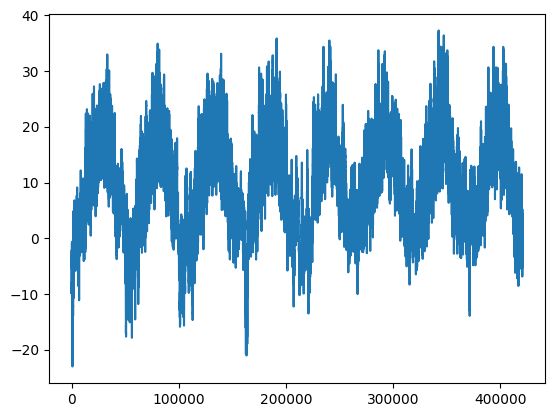

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

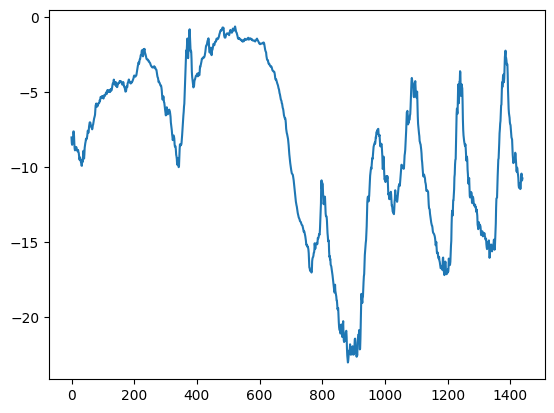

In [5]:
plt.plot(range(1440), temperature[:1440])

In [6]:

num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [9]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [10]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


Computing the common-sense baseline MAE

In [11]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


Training and evaluating a densely connected model

In [12]:
import keras
from keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [13]:
history = model.fit(train_dataset, epochs=10,
                    validation_data = val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 9s 10ms/step - loss: 12.6169 - mae: 2.7457 - val_loss: 11.5658 - val_mae: 2.7001
Epoch 2/10
819/819 [==============================] - 8s 10ms/step - loss: 9.0949 - mae: 2.3716 - val_loss: 10.3482 - val_mae: 2.5436
Epoch 3/10
819/819 [==============================] - 8s 10ms/step - loss: 8.3441 - mae: 2.2734 - val_loss: 10.0928 - val_mae: 2.5131
Epoch 4/10
819/819 [==============================] - 9s 10ms/step - loss: 7.8413 - mae: 2.2048 - val_loss: 11.4940 - val_mae: 2.6832
Epoch 5/10
819/819 [==============================] - 9s 11ms/step - loss: 7.5344 - mae: 2.1623 - val_loss: 11.8284 - val_mae: 2.7257
Epoch 6/10
819/819 [==============================] - 9s 10ms/step - loss: 7.2655 - mae: 2.1247 - val_loss: 10.5451 - val_mae: 2.5663
Epoch 7/10
819/819 [==============================] - 9s 11ms/step - loss: 7.0483 - mae: 2.0927 - val_loss: 11.1115 - val_mae: 2.6529
Epoch 8/10
819/819 [==============================] - 8s 10ms

In [14]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 3s 6ms/step - loss: 11.2569 - mae: 2.6438
Test MAE: 2.64


In [24]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                1984      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2001 (7.82 KB)
Trainable params: 2001 (7.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<ipython-input-15-cfa89b244b5a>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss,"bo", color="grey",  label="Training MAE")
<ipython-input-15-cfa89b244b5a>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")


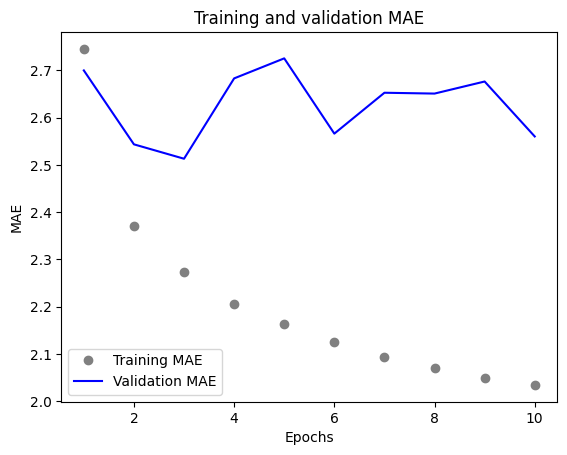

In [15]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss,"bo", color="grey",  label="Training MAE")
plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

1D convolutional model

In [16]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 14s 16ms/step - loss: 22.5157 - mae: 3.6792 - val_loss: 15.1129 - val_mae: 3.0754
Epoch 2/10
819/819 [==============================] - 13s 16ms/step - loss: 15.3195 - mae: 3.1093 - val_loss: 15.9912 - val_mae: 3.1743
Epoch 3/10
819/819 [==============================] - 13s 16ms/step - loss: 14.0990 - mae: 2.9791 - val_loss: 14.2328 - val_mae: 2.9749
Epoch 4/10
819/819 [==============================] - 13s 15ms/step - loss: 13.1655 - mae: 2.8778 - val_loss: 14.0730 - val_mae: 2.9718
Epoch 5/10
819/819 [==============================] - 13s 16ms/step - loss: 12.4539 - mae: 2.7975 - val_loss: 13.6871 - val_mae: 2.8999
Epoch 6/10
819/819 [==============================] - 13s 15ms/step - loss: 11.9541 - mae: 2.7389 - val_loss: 16.7237 - val_mae: 3.2250
Epoch 7/10
819/819 [==============================] - 13s 15ms/step - loss: 11.5841 - mae: 2.6953 - val_loss: 16.2268 - val_mae: 3.1634
Epoch 8/10
819/819 [============================

In [17]:
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 3s 8ms/step - loss: 14.6499 - mae: 3.0384
Test MAE: 3.04


In [25]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                1984      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2001 (7.82 KB)
Trainable params: 2001 (7.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<ipython-input-18-b887b99572a7>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss,"bo", color="grey", label="Training MAE")
<ipython-input-18-b887b99572a7>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")


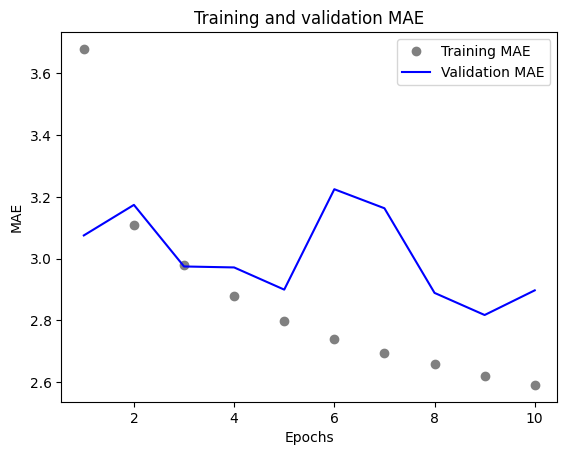

In [18]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss,"bo", color="grey", label="Training MAE")
plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Model on long short term model.

In [19]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 46s 54ms/step - loss: 40.3756 - mae: 4.6150 - val_loss: 12.1891 - val_mae: 2.6740
Epoch 2/10
819/819 [==============================] - 43s 52ms/step - loss: 10.8836 - mae: 2.5680 - val_loss: 9.2729 - val_mae: 2.3872
Epoch 3/10
819/819 [==============================] - 44s 54ms/step - loss: 9.7015 - mae: 2.4343 - val_loss: 9.4580 - val_mae: 2.4124
Epoch 4/10
819/819 [==============================] - 39s 48ms/step - loss: 9.3433 - mae: 2.3860 - val_loss: 9.3026 - val_mae: 2.3846
Epoch 5/10
819/819 [==============================] - 42s 51ms/step - loss: 9.0837 - mae: 2.3502 - val_loss: 9.5579 - val_mae: 2.3993
Epoch 6/10
819/819 [==============================] - 42s 51ms/step - loss: 8.9095 - mae: 2.3227 - val_loss: 9.6277 - val_mae: 2.4076
Epoch 7/10
819/819 [==============================] - 43s 53ms/step - loss: 8.6738 - mae: 2.2900 - val_loss: 9.8604 - val_mae: 2.4282
Epoch 8/10
819/819 [==============================] - 43s 5

In [20]:
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 9s 20ms/step - loss: 11.0166 - mae: 2.5931
Test MAE: 2.59


In [26]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                1984      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2001 (7.82 KB)
Trainable params: 2001 (7.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<ipython-input-21-95530881361e>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss,"bo", color="grey", label="Training MAE")
<ipython-input-21-95530881361e>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")


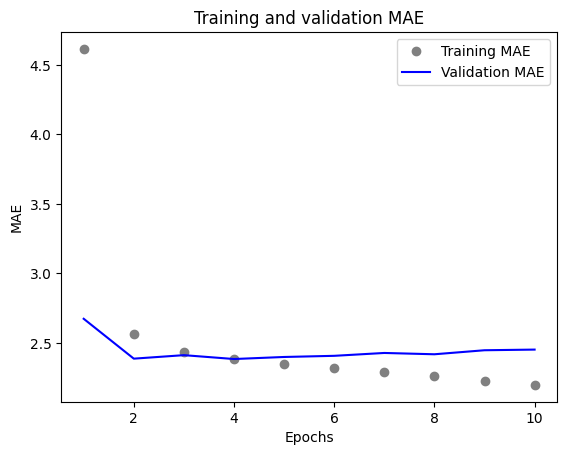

In [21]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss,"bo", color="grey", label="Training MAE")
plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

LSTM with dropout regularization

In [22]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 62s 73ms/step - loss: 50.8587 - mae: 5.3193 - val_loss: 14.1055 - val_mae: 2.8216
Epoch 2/10
819/819 [==============================] - 60s 73ms/step - loss: 20.0957 - mae: 3.4384 - val_loss: 9.9671 - val_mae: 2.4432
Epoch 3/10
819/819 [==============================] - 59s 72ms/step - loss: 18.0908 - mae: 3.2707 - val_loss: 9.5288 - val_mae: 2.4000
Epoch 4/10
819/819 [==============================] - 58s 71ms/step - loss: 17.3134 - mae: 3.2000 - val_loss: 9.5690 - val_mae: 2.4074
Epoch 5/10
819/819 [==============================] - 61s 74ms/step - loss: 16.7479 - mae: 3.1451 - val_loss: 9.7337 - val_mae: 2.4260
Epoch 6/10
819/819 [==============================] - 60s 73ms/step - loss: 16.1844 - mae: 3.0971 - val_loss: 9.4703 - val_mae: 2.3861
Epoch 7/10
819/819 [==============================] - 59s 72ms/step - loss: 15.7871 - mae: 3.0639 - val_loss: 9.5156 - val_mae: 2.4022
Epoch 8/10
819/819 [==============================] - 

In [23]:
model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 7s 17ms/step - loss: 10.6921 - mae: 2.5830
Test MAE: 2.58


In [27]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                1984      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2001 (7.82 KB)
Trainable params: 2001 (7.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<ipython-input-28-b887b99572a7>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss,"bo", color="grey", label="Training MAE")
<ipython-input-28-b887b99572a7>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")


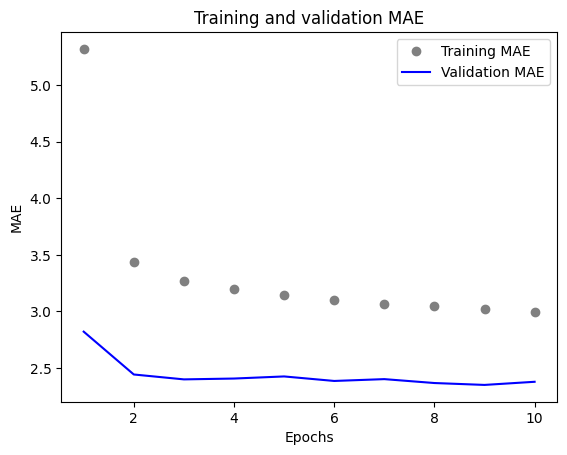

In [28]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss,"bo", color="grey", label="Training MAE")
plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

LSTM with 16 units

In [29]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 94s 112ms/step - loss: 39.8044 - mae: 4.5872 - val_loss: 13.1436 - val_mae: 2.7344
Epoch 2/10
819/819 [==============================] - 88s 107ms/step - loss: 10.3756 - mae: 2.4979 - val_loss: 9.6161 - val_mae: 2.4254
Epoch 3/10
819/819 [==============================] - 84s 102ms/step - loss: 8.8997 - mae: 2.3267 - val_loss: 9.4961 - val_mae: 2.4079
Epoch 4/10
819/819 [==============================] - 86s 105ms/step - loss: 8.3279 - mae: 2.2478 - val_loss: 9.7730 - val_mae: 2.4479
Epoch 5/10
819/819 [==============================] - 90s 110ms/step - loss: 7.8923 - mae: 2.1891 - val_loss: 9.5072 - val_mae: 2.4166
Epoch 6/10
819/819 [==============================] - 91s 110ms/step - loss: 7.4652 - mae: 2.1314 - val_loss: 10.1777 - val_mae: 2.4978
Epoch 7/10
819/819 [==============================] - 86s 105ms/step - loss: 7.1916 - mae: 2.0917 - val_loss: 10.1427 - val_mae: 2.4901
Epoch 8/10
819/819 [==============================

In [30]:
model = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 17s 39ms/step - loss: 10.9590 - mae: 2.6132
Test MAE: 2.61


In [31]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm_2 (LSTM)               (None, 120, 16)           1984      
                                                                 
 lstm_3 (LSTM)               (None, 16)                2112      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4113 (16.07 KB)
Trainable params: 4113 (16.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<ipython-input-32-b887b99572a7>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss,"bo", color="grey", label="Training MAE")
<ipython-input-32-b887b99572a7>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")


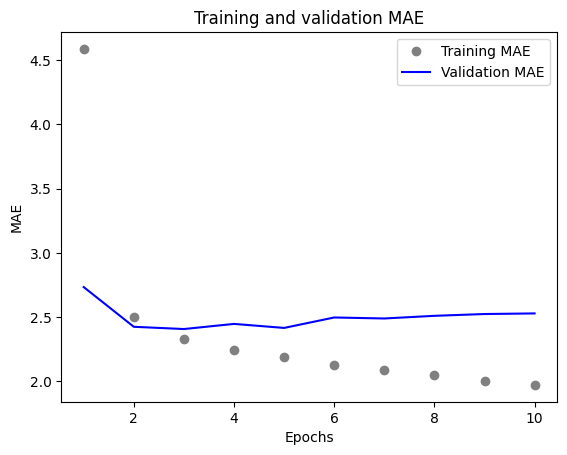

In [32]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss,"bo", color="grey", label="Training MAE")
plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

LSTM with 8 units

In [33]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(8)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 71s 83ms/step - loss: 79.6672 - mae: 6.9297 - val_loss: 41.9105 - val_mae: 4.8610
Epoch 2/10
819/819 [==============================] - 67s 82ms/step - loss: 25.3222 - mae: 3.7306 - val_loss: 14.5148 - val_mae: 2.8567
Epoch 3/10
819/819 [==============================] - 72s 88ms/step - loss: 12.2402 - mae: 2.7046 - val_loss: 9.8037 - val_mae: 2.4165
Epoch 4/10
819/819 [==============================] - 70s 86ms/step - loss: 10.2222 - mae: 2.4900 - val_loss: 9.4375 - val_mae: 2.3967
Epoch 5/10
819/819 [==============================] - 69s 84ms/step - loss: 9.7339 - mae: 2.4286 - val_loss: 9.2758 - val_mae: 2.3739
Epoch 6/10
819/819 [==============================] - 70s 85ms/step - loss: 9.4661 - mae: 2.3968 - val_loss: 9.0749 - val_mae: 2.3388
Epoch 7/10
819/819 [==============================] - 71s 87ms/step - loss: 9.1797 - mae: 2.3638 - val_loss: 9.0719 - val_mae: 2.3556
Epoch 8/10
819/819 [==============================] - 65

In [34]:
model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 14s 31ms/step - loss: 10.8064 - mae: 2.5379
Test MAE: 2.54


In [35]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm_4 (LSTM)               (None, 120, 8)            736       
                                                                 
 lstm_5 (LSTM)               (None, 8)                 544       
                                                                 
 dense_6 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1289 (5.04 KB)
Trainable params: 1289 (5.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<ipython-input-36-b887b99572a7>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss,"bo", color="grey", label="Training MAE")
<ipython-input-36-b887b99572a7>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")


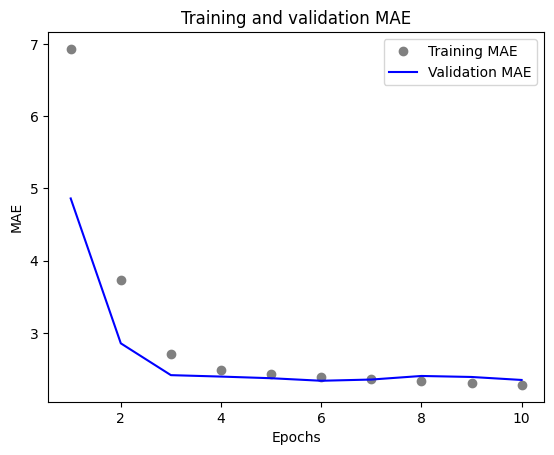

In [36]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss,"bo", color="grey", label="Training MAE")
plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

LSTM dropout regularization with 8 units

In [37]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(8, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 117s 138ms/step - loss: 71.7768 - mae: 6.4964 - val_loss: 33.6940 - val_mae: 4.2780
Epoch 2/10
819/819 [==============================] - 113s 138ms/step - loss: 31.3996 - mae: 4.1900 - val_loss: 14.0868 - val_mae: 2.8070
Epoch 3/10
819/819 [==============================] - 113s 138ms/step - loss: 24.5703 - mae: 3.7454 - val_loss: 11.1344 - val_mae: 2.5491
Epoch 4/10
819/819 [==============================] - 113s 137ms/step - loss: 22.4889 - mae: 3.5925 - val_loss: 10.3580 - val_mae: 2.4725
Epoch 5/10
819/819 [==============================] - 112s 137ms/step - loss: 21.1321 - mae: 3.4896 - val_loss: 10.5567 - val_mae: 2.5183
Epoch 6/10
819/819 [==============================] - 113s 138ms/step - loss: 20.1514 - mae: 3.4070 - val_loss: 10.1162 - val_mae: 2.4608
Epoch 7/10
819/819 [==============================] - 113s 138ms/step - loss: 19.3798 - mae: 3.3494 - val_loss: 9.6254 - val_mae: 2.4073
Epoch 8/10
819/819 [===============

In [38]:
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 12s 27ms/step - loss: 10.8822 - mae: 2.5639
Test MAE: 2.56


In [49]:
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 120, 14)]         0         
                                                                 
 gru (GRU)                   (None, 16)                1536      
                                                                 
 dense_10 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1553 (6.07 KB)
Trainable params: 1553 (6.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<ipython-input-39-b887b99572a7>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss,"bo", color="grey", label="Training MAE")
<ipython-input-39-b887b99572a7>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")


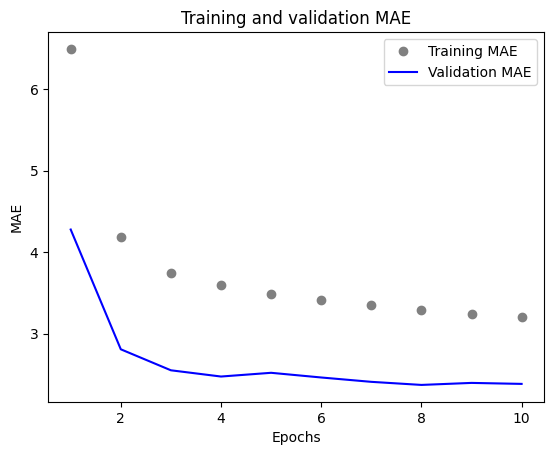

In [39]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss,"bo", color="grey", label="Training MAE")
plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Bidirectional Model

In [40]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)



callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                     callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 54s 62ms/step - loss: 30.5831 - mae: 3.9660 - val_loss: 11.0872 - val_mae: 2.5946
Epoch 2/10
819/819 [==============================] - 53s 64ms/step - loss: 9.6804 - mae: 2.4257 - val_loss: 9.8813 - val_mae: 2.4341
Epoch 3/10
819/819 [==============================] - 50s 62ms/step - loss: 8.7913 - mae: 2.3034 - val_loss: 9.6049 - val_mae: 2.3979
Epoch 4/10
819/819 [==============================] - 51s 62ms/step - loss: 8.3857 - mae: 2.2491 - val_loss: 9.8103 - val_mae: 2.4275
Epoch 5/10
819/819 [==============================] - 51s 62ms/step - loss: 7.9856 - mae: 2.2006 - val_loss: 10.5208 - val_mae: 2.4985
Epoch 6/10
819/819 [==============================] - 52s 63ms/step - loss: 7.5670 - mae: 2.1459 - val_loss: 10.5943 - val_mae: 2.5232
Epoch 7/10
819/819 [==============================] - 52s 63ms/step - loss: 7.2250 - mae: 2.0989 - val_loss: 10.5027 - val_mae: 2.5129
Epoch 8/10
819/819 [==============================] - 51s

In [41]:
model = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 10s 22ms/step - loss: 10.4643 - mae: 2.5564
Test MAE: 2.56


In [50]:
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 120, 14)]         0         
                                                                 
 gru (GRU)                   (None, 16)                1536      
                                                                 
 dense_10 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1553 (6.07 KB)
Trainable params: 1553 (6.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<ipython-input-42-b887b99572a7>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss,"bo", color="grey", label="Training MAE")
<ipython-input-42-b887b99572a7>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")


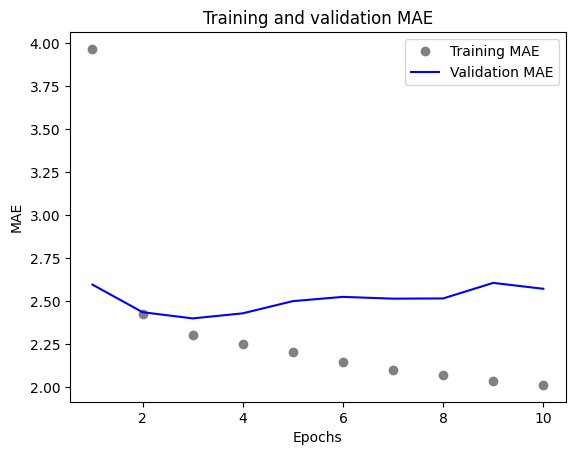

In [42]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss,"bo", color="grey", label="Training MAE")
plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

1D convent and LSTM Model

In [43]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 128))(x)  # Reshape the data to be 3D
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 16s 17ms/step - loss: 44.7844 - mae: 4.9988 - val_loss: 26.8447 - val_mae: 4.0124
Epoch 2/10
819/819 [==============================] - 13s 15ms/step - loss: 17.1598 - mae: 3.2025 - val_loss: 21.9196 - val_mae: 3.6945
Epoch 3/10
819/819 [==============================] - 13s 15ms/step - loss: 14.2177 - mae: 2.9231 - val_loss: 22.0025 - val_mae: 3.7253
Epoch 4/10
819/819 [==============================] - 13s 15ms/step - loss: 12.6789 - mae: 2.7559 - val_loss: 23.2176 - val_mae: 3.8812
Epoch 5/10
819/819 [==============================] - 13s 15ms/step - loss: 11.5743 - mae: 2.6224 - val_loss: 22.0175 - val_mae: 3.7623
Epoch 6/10
819/819 [==============================] - 13s 15ms/step - loss: 10.6885 - mae: 2.5158 - val_loss: 23.4542 - val_mae: 3.8383
Epoch 7/10
819/819 [==============================] - 13s 15ms/step - loss: 9.9750 - mae: 2.4246 - val_loss: 24.6049 - val_mae: 3.9469
Epoch 8/10
819/819 [=============================

In [44]:
model = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 4s 8ms/step - loss: 22.7639 - mae: 3.7856
Test MAE: 3.79


In [51]:
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 120, 14)]         0         
                                                                 
 gru (GRU)                   (None, 16)                1536      
                                                                 
 dense_10 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1553 (6.07 KB)
Trainable params: 1553 (6.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<ipython-input-45-a53040850538>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss,"bo", color="grey", label="Training MAE")
<ipython-input-45-a53040850538>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")


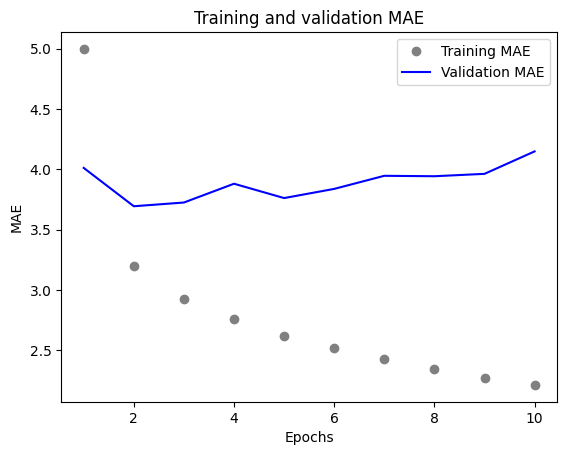

In [45]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss,"bo", color="grey", label="Training MAE")
plt.plot(epochs,  val_loss,"b", color="blue", label="Validation MAE")

plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Simple GRU Model

In [46]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 43s 51ms/step - loss: 37.1329 - mae: 4.3952 - val_loss: 11.6304 - val_mae: 2.5882
Epoch 2/10
819/819 [==============================] - 39s 47ms/step - loss: 10.2817 - mae: 2.4953 - val_loss: 9.2774 - val_mae: 2.3575
Epoch 3/10
819/819 [==============================] - 44s 54ms/step - loss: 9.4925 - mae: 2.4045 - val_loss: 9.3464 - val_mae: 2.3591
Epoch 4/10
819/819 [==============================] - 45s 54ms/step - loss: 9.2424 - mae: 2.3748 - val_loss: 9.8014 - val_mae: 2.4099
Epoch 5/10
819/819 [==============================] - 40s 49ms/step - loss: 9.0399 - mae: 2.3511 - val_loss: 9.2658 - val_mae: 2.3546
Epoch 6/10
819/819 [==============================] - 43s 52ms/step - loss: 8.8501 - mae: 2.3286 - val_loss: 9.4137 - val_mae: 2.3698
Epoch 7/10
819/819 [==============================] - 42s 52ms/step - loss: 8.6593 - mae: 2.3032 - val_loss: 10.0512 - val_mae: 2.4366
Epoch 8/10
819/819 [==============================] - 42s 

In [47]:
model = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 7s 16ms/step - loss: 10.0757 - mae: 2.5063
Test MAE: 2.51


In [52]:
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 120, 14)]         0         
                                                                 
 gru (GRU)                   (None, 16)                1536      
                                                                 
 dense_10 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1553 (6.07 KB)
Trainable params: 1553 (6.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


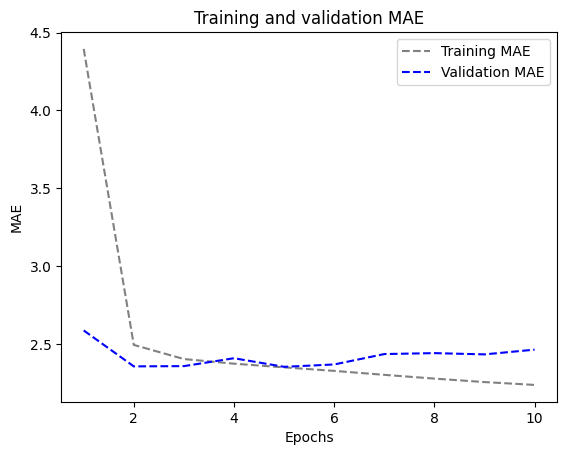

In [48]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

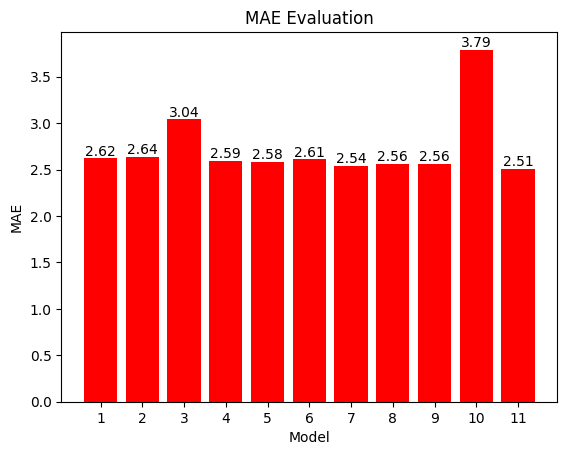

In [2]:
import matplotlib.pyplot as plt

Models = ("1","2","3","4","5","6","7","8","9","10","11")
Mae = (2.62,2.64,3.04,2.59,2.58,2.61,2.54,2.56,2.56,3.79,2.51)

# MAE Evaluation
plt.bar(Models, Mae, color="red")
plt.title("MAE Evaluation")
plt.xlabel("Model")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()

##Time Series Forecasting Analysis

###Models Developed and MAE Evaluation

Model 1: Baseline Model

MAE: 2.62



Model 2: Basic machine learning model


MAE: 2.64


Model 3: Convolutional Neural Network (CNN)

MAE: 3.04


Model 4: LSTM

MAE: 2.59

Model 5: LSTM (dropout regularization)

MAE: 2.58

Model 6: LSTM (16 units)

MAE: 2.61

Model 7: LSTM (8 units)

Method: Gated Recurrent Unit network.

MAE: 2.54

Model 8: LSTM (dropout regularization 8 units)

MAE: 2.56

Model 9: LSTM (Bidirectional)

MAE: 2.56

Model 10: Hybrid CNN + LSTM

Method: Combination of CNN and LSTM.

MAE: 3.79

Model 11:Simple GRU ( Gated Recurrent Unit)

MAE: 2.51

##Key Findings
LSTM and GRU Models: Both effectively captured temporal dependencies, with the best Model 7, LSTM (8 units) achieving the lowest MAE of 2.54.
Hybrid Models: The combination of CNN and LSTM (Model 10) did not perform well, likely due to the challenges in maintaining sequence integrity.
Model Enhancements: Fine-tuning hyperparameters and configurations of LSTM significantly improved performance.

##MAE Evaluation
The Bar chart displays the MAE for each model, highlighting the comparative performance. The best-performing model was the Simple GRU ( Gated Recurrent Unit) with an MAE of 2.51, followed closely by various configurations of LSTM models.

##Conclusion
For accurate time series forecasting, advanced recurrent neural network architectures like LSTM and GRU are recommended due to their ability to handle long-term dependencies and avoid issues such as the vanishing gradient problem. Optimizing model configurations and hyperparameters is crucial for achieving the best performance. Hybrid models, although promising, need careful tuning to maintain the sequence data's integrity.